In [1]:
from pytao import Tao
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

#needed for lattice_init
%env FACET2_LATTICE /sdf/home/s/sanjeev/github/facet2-lattice
print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 
#

env: FACET2_LATTICE=/sdf/home/s/sanjeev/github/facet2-lattice
Make sure enviornment was set!:   /sdf/home/s/sanjeev/github/facet2-lattice


In [2]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches

In [3]:
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

# Start tao

In [4]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [5]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
tao.ele_gen_attribs(elements[0])

{'INHERIT_FROM_FORK': False,
 'SPIN_DN_DPZ_X': 0.0,
 'units#SPIN_DN_DPZ_X': '',
 'SPIN_DN_DPZ_Y': 0.0,
 'units#SPIN_DN_DPZ_Y': '',
 'SPIN_DN_DPZ_Z': 0.0,
 'units#SPIN_DN_DPZ_Z': '',
 'CMAT_11': 0.0,
 'units#CMAT_11': '',
 'CMAT_12': 0.0,
 'units#CMAT_12': '',
 'CMAT_21': 0.0,
 'units#CMAT_21': '',
 'CMAT_22': 0.0,
 'units#CMAT_22': '',
 'MODE_FLIP': False,
 'P0C_START': 5978200.40422692,
 'units#P0C_START': 'eV',
 'E_TOT_START': 6000000.0,
 'units#E_TOT_START': 'eV',
 'P0C': 5978200.40422692,
 'units#P0C': 'eV',
 'E_TOT': 6000000.0,
 'units#E_TOT': 'eV'}

In [6]:
?tao.lat_list

Signature:
tao.lat_list(
    elements,
    who,
    *,
    ix_uni='',
    ix_branch='',
    which='model',
    flags='-array_out -track_only',
    verbose=False,
    as_dict=True,
    raises=True,
)
Docstring:
Output list of parameters at ends of lattice elements

Parameters
----------
elements
who
ix_uni : optional
ix_branch : optional
which : default=model
flags : optional, default=-array_out -track_only

Returns
-------
string_list
    if ('-array_out' not in flags) or (who in ['ele.name', 'ele.key'])
integer_array
    if '-array_out' in flags and who in ['orbit.state', 'ele.ix_ele']
real_array
    if ('-array_out' in flags) or ('real:' in who) 

Notes
-----
Command syntax:
  python lat_list {flags} {ix_uni}@{ix_branch}>>{elements}|{which} {who}

Where:
 Optional {flags} are:
  -no_slaves : If present, multipass_slave and super_slave elements will not be matched to.
  -track_only : If present, lord elements will not be matched to.
  -index_order : If present, order elements by eleme

In [7]:
floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1845756/1758558823.py:1: SyntaxWarning: invalid escape sequence '\s'
  floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',


Index ElementName ElementType         s        ds         X    Y  \
1        1        DL00       Drift  -0.86905  -0.86905  10.69357  0.0   
26      26       DL01H       Drift   1.03220   0.09012   9.60305  0.0   
51      51      L0BF#2     Lcavity   5.25643   0.33713   7.18014  0.0   
76      76     QE10441  Quadrupole   8.50702   0.10800   5.31568  0.0   
101    101   QE10511#1  Quadrupole  11.14513   0.05400   3.80475  0.0   
126    126    BPM10581     Monitor  14.40167   0.00000   1.93688  0.0   
151    151   QB10731#1  Quadrupole  17.73408   0.05340   0.26540  0.0   

              Z    Theta  Phi  Psi  
1    1001.56206 -0.61087  0.0  0.0  
26   1003.11948 -0.61087  0.0  0.0  
51   1006.57976 -0.61087  0.0  0.0  
76   1009.24248 -0.61087  0.0  0.0  
101  1011.40031 -0.61087  0.0  0.0  
126  1014.06791 -0.61087  0.0  0.0  
151  1016.91774 -0.30543  0.0  0.0

In [8]:
floorplan[floorplan.s<9.0].head(60)

Index ElementName ElementType        s        ds         X    Y  \
1       1        DL00       Drift -0.86905  -0.86905  10.69357  0.0   
2       2   LOADLOCKF       Drift  0.00000   0.86905  10.19510  0.0   
3       3      BEGINJ      Marker  0.00000   0.00000  10.19510  0.0   
4       4    SOL10111    Solenoid  0.00000   0.00000  10.19510  0.0   
5       5    CATHODEF  Instrument  0.00000   0.00000  10.19510  0.0   
6       6       DL01A       Drift  0.09729   0.09729  10.13930  0.0   
7       7  SOL10121#1    Solenoid  0.19729   0.10000  10.08194  0.0   
8       8     YC10122     VKicker  0.19729   0.00000  10.08194  0.0   
9       9     XC10121     HKicker  0.19729   0.00000  10.08194  0.0   
10     10     SQ10122   Multipole  0.19729   0.00000  10.08194  0.0   
11     11     CQ10121   Multipole  0.19729   0.00000  10.08194  0.0   
12     12  SOL10121#2    Solenoid  0.29729   0.10000  10.02458  0.0   
13     13       DL01B       Drift  0.37580   0.07851   9.97955  0.0   
14     14     VV10155  Instrument  0.37580   0.00000   9.97955  0.0   
15     15       DL01C       Drift  0.49189   0.11609   9.91296  0.0   
16     16    MIR10181  Instrument  0.49189   0.00000   9.91296  0.0   
17     17       DL01D       Drift  0.57303   0.08114   9.86643  0.0   
18     18     VV10215  Instrument  0.57303   0.00000   9.86643  0.0   
19     19       DL01E       Drift  0.69935   0.12632   9.79397  0.0   
20     20    BPM10221     Monitor  0.69935   0.00000   9.79397  0.0   
21     21       DL01F       Drift  0.70786   0.00851   9.78909  0.0   
22     22     XC10221     HKicker  0.70786   0.00000   9.78909  0.0   
23     23     YC10222     VKicker  0.70786   0.00000   9.78909  0.0   
24     24       DL01G       Drift  0.94208   0.23423   9.65474  0.0   
25     25     PR10241     Monitor  0.94208   0.00000   9.65474  0.0   
26     26       DL01H       Drift  1.03220   0.09012   9.60305  0.0   
27     27      L0AF#1     Lcavity  1.09085   0.05865   9.56942  0.0   
28     28      DLFDAF      Marker  1.09085   0.00000   9.56942  0.0   
29     29      L0AF#2     Lcavity  1.93952   0.84867   9.08264  0.0   
30     30     YC10312     VKicker  1.93952   0.00000   9.08264  0.0   
31     31     XC10311     HKicker  1.93952   0.00000   9.08264  0.0   
32     32      L0AF#3     Lcavity  2.57983   0.64030   8.71537  0.0   
33     33     L0AFMID      Marker  2.57983   0.00000   8.71537  0.0   
34     34      L0AF#4     Lcavity  4.06653   1.48670   7.86264  0.0   
35     35     OUTCPAF      Marker  4.06653   0.00000   7.86264  0.0   
36     36      L0AF#5     Lcavity  4.12745   0.06092   7.82770  0.0   
37     37     L0AFEND      Marker  4.12745   0.00000   7.82770  0.0   
38     38    L0AFWAKE      Marker  4.12745   0.00000   7.82770  0.0   
39     39     FLNGAF2      Marker  4.12745   0.00000   7.82770  0.0   
40     40        DL02       Drift  4.35839   0.23094   7.69523  0.0   
41     41     QA10361  Quadrupole  4.46639   0.10800   7.63329  0.0   
42     42       DL03A       Drift  4.56087   0.09448   7.57909  0.0   
43     43     PH10365  Instrument  4.56087   0.00000   7.57909  0.0   
44     44       DL03B       Drift  4.68677   0.12589   7.50688  0.0   
45     45   QA10371#1  Quadrupole  4.74077   0.05400   7.47591  0.0   
46     46    BPM10371     Monitor  4.74077   0.00000   7.47591  0.0   
47     47   QA10371#2  Quadrupole  4.79477   0.05400   7.44494  0.0   
48     48        DL04       Drift  4.86065   0.06589   7.40715  0.0   
49     49      L0BF#1     Lcavity  4.91930   0.05865   7.37351  0.0   
50     50      DLFDBF      Marker  4.91930   0.00000   7.37351  0.0   
51     51      L0BF#2     Lcavity  5.25643   0.33713   7.18014  0.0   
52     52     YC10382     VKicker  5.25643   0.00000   7.18014  0.0   
53     53     XC10381     HKicker  5.25643   0.00000   7.18014  0.0   
54     54      L0BF#3     Lcavity  6.40828   1.15185   6.51947  0.0   
55     55     L0BFMID      Marker  6.40828   0.00000   6.51947  0.0   
56     56      L0BF#4     Lc

In [9]:
floorplan[floorplan.ElementName.str.contains('IP')][::1].head(5)

Index ElementName ElementType          s       ds    X    Y        Z  \
1528   1528     IPOTR1P     Monitor  994.64281  0.00000 -0.0  0.0  1993.74   
1530   1530      IPOTR1     Monitor  994.73281  0.00000 -0.0  0.0  1993.83   
1533   1533         MIP      Marker  994.77281  0.00000 -0.0  0.0  1993.87   
1535   1535       IPWS1     Monitor  994.81281  0.00000 -0.0  0.0  1993.91   
1539   1539      IPOTR2     Monitor  995.99281  0.00000 -0.0  0.0  1995.09   

      Theta  Phi  Psi  
1528    0.0  0.0  0.0  
1530    0.0  0.0  0.0  
1533    0.0  0.0  0.0  
1535    0.0  0.0  0.0  
1539    0.0  0.0  0.0

In [10]:
floorplan[floorplan.ElementType.str.contains('cavity')][::1].head(25)

Index ElementName ElementType         s       ds        X    Y  \
27      27      L0AF#1     Lcavity   1.09085  0.05865  9.56942  0.0   
29      29      L0AF#2     Lcavity   1.93952  0.84867  9.08264  0.0   
32      32      L0AF#3     Lcavity   2.57983  0.64030  8.71537  0.0   
34      34      L0AF#4     Lcavity   4.06653  1.48670  7.86264  0.0   
36      36      L0AF#5     Lcavity   4.12745  0.06092  7.82770  0.0   
49      49      L0BF#1     Lcavity   4.91930  0.05865  7.37351  0.0   
51      51      L0BF#2     Lcavity   5.25643  0.33713  7.18014  0.0   
54      54      L0BF#3     Lcavity   6.40828  1.15185  6.51947  0.0   
56      56      L0BF#4     Lcavity   7.55984  1.15156  5.85896  0.0   
59      59      L0BF#5     Lcavity   7.89498  0.33514  5.66673  0.0   
61      61      L0BF#6     Lcavity   7.95590  0.06092  5.63179  0.0   
96      96  TCY10490#1     Lcavity  10.70494  0.33401  4.05723  0.0   
99      99  TCY10490#2     Lcavity  11.03896  0.33401  3.86565  0.0   
176    176    K11_1B#1     Lcavity  21.32527  1.43460 -0.00000  0.0   
179    179    K11_1B#2     Lcavity  22.75987  1.43460 -0.00000  0.0   
185    185    K11_1C#1     Lcavity  24.45682  1.52205 -0.00000  0.0   
188    188    K11_1C#2     Lcavity  25.97887  1.52205 -0.00000  0.0   
189    189      K11_1D     Lcavity  29.02297  3.04410 -0.00000  0.0   
195    195    K11_2A#1     Lcavity  29.51657  0.32560 -0.00000  0.0   
197    197    K11_2A#2     Lcavity  29.80357  0.28700 -0.00000  0.0   
199    199    K11_2A#3     Lcavity  32.23507  2.43150 -0.00000  0.0   
200    200      K11_2B     Lcavity  35.10427  2.86920 -0.00000  0.0   
206    206    K11_2C#1     Lcavity  36.80122  1.52205 -0.00000  0.0   
209    209    K11_2C#2     Lcavity  38.32327  1.52205 -0.00000  0.0   
217    217      L1XF#1     Lcavity  39.08224  0.29740 -0.00000  0.0   

              Z    Theta  Phi  Psi  
27   1003.16752 -0.61087  0.0  0.0  
29   1003.86271 -0.61087  0.0  0.0  
32   1004.38721 -0.61087  0.0  0.0  
34   1005.60505 -0.61087  0.0  0.0  
36   1005.65495 -0.61087  0.0  0.0  
49   1006.30360 -0.61087  0.0  0.0  
51   1006.57976 -0.61087  0.0  0.0  
54   1007.52330 -0.61087  0.0  0.0  
56   1008.46660 -0.61087  0.0  0.0  
59   1008.74113 -0.61087  0.0  0.0  
61   1008.79103 -0.61087  0.0  0.0  
96   1011.03973 -0.61087  0.0  0.0  
99   1011.31334 -0.61087  0.0  0.0  
176  1020.46968  0.00000  0.0  0.0  
179  1021.90428  0.00000  0.0  0.0  
185  1023.60123  0.00000  0.0  0.0  
188  1025.12328  0.00000  0.0  0.0  
189  1028.16738  0.00000  0.0  0.0  
195  1028.66098  0.00000  0.0  0.0  
197  1028.94798  0.00000  0.0  0.0  
199  1031.37948  0.00000  0.0  0.0  
200  1034.24868  0.00000  0.0  0.0  
206  1035.94563  0.00000  0.0  0.0  
209  1037.46768  0.00000  0.0  0.0  
217  1038.22665  0.00000  0.0  0.0

In [11]:
tao.ele_gen_attribs('K11_2C#1')

{'L': 1.52205,
 'units#L': 'm',
 'TILT': 0.0,
 'units#TILT': 'rad',
 'GRADIENT_TOT': 15569690.2638638,
 'units#GRADIENT_TOT': 'eV/m',
 'GRADIENT': 15569690.2638638,
 'units#GRADIENT': 'eV/m',
 'GRADIENT_ERR': 0.0,
 'units#GRADIENT_ERR': 'eV/m',
 'VOLTAGE': 23697847.066114,
 'units#VOLTAGE': 'Volt',
 'VOLTAGE_ERR': 0.0,
 'units#VOLTAGE_ERR': 'Volt',
 'FRINGE_TYPE': 'Full',
 'FRINGE_AT': 'Entrance_End',
 'SPIN_FRINGE_ON': True,
 'RF_FREQUENCY': 2856000000.0,
 'units#RF_FREQUENCY': 'Hz',
 'RF_WAVELENGTH': 0.104969348039216,
 'units#RF_WAVELENGTH': 'm',
 'STATIC_LINEAR_MAP': False,
 'LONGITUDINAL_MODE': 0,
 'AUTOSCALE_AMPLITUDE': True,
 'AUTOSCALE_PHASE': True,
 'E_LOSS': 0.0,
 'units#E_LOSS': 'eV',
 'CAVITY_TYPE': 'Traveling_Wave',
 'PHI0': -0.0569444444444444,
 'units#PHI0': 'rad/2pi',
 'PHI0_ERR': 0.0,
 'units#PHI0_ERR': 'rad/2pi',
 'PHI0_MULTIPASS': 0.0,
 'units#PHI0_MULTIPASS': 'rad/2pi',
 'PHI0_AUTOSCALE': 0.0,
 'units#PHI0_AUTOSCALE': 'rad/2pi',
 'FIELD_AUTOSCALE': 1.0,
 'units#FIEL

In [12]:
#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])

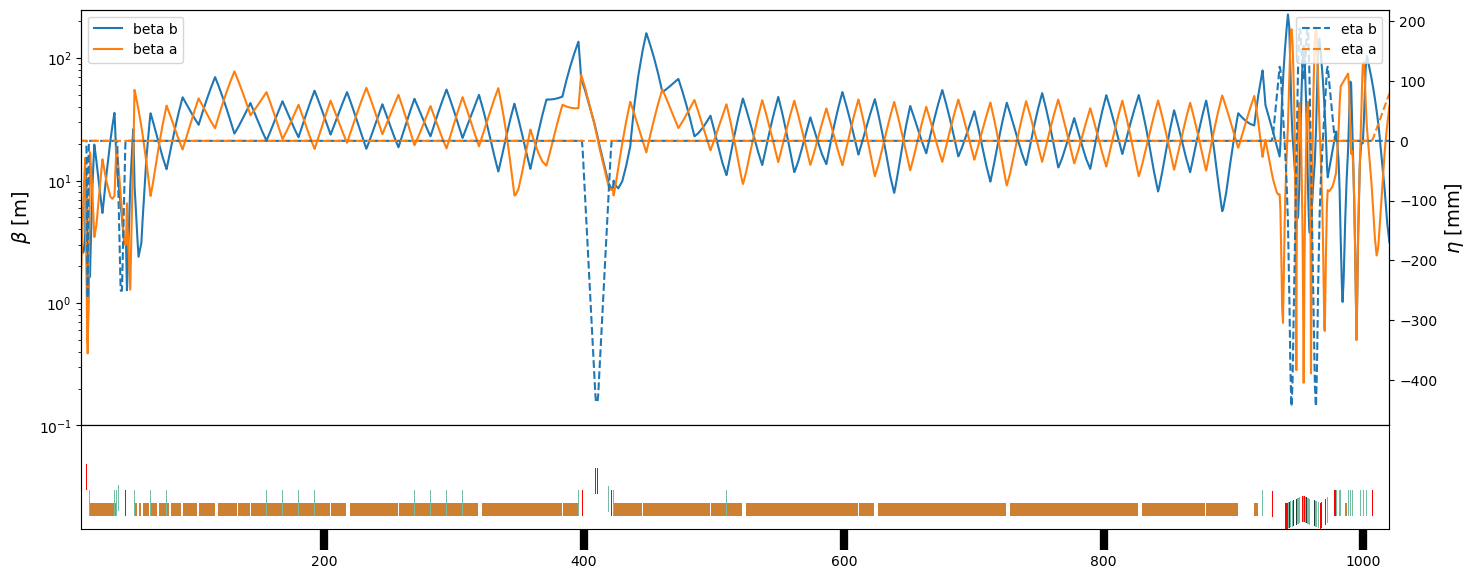

In [13]:
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

## Track particles (no csr)

In [14]:
tao.cmd('set beam_init n_particle = 10000') # limit to 10k particles for now

[]

In [15]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [16]:
P = ParticleGroup('/sdf/home/s/sanjeev/github/facet2-lattice/bmad/beams/L0AFEND.h5')
P.data.update(resample_particles(P, n=10000))
P.gamma=P.gamma-np.mean(P.gamma)+tao.lat_list('L0AFEND','ele.e_tot')[0]*1e-6/0.511;
P.twiss_match(plane='y',beta=tao.lat_list('L0AFEND','ele.a.beta'),alpha=tao.lat_list('L0AFEND','ele.a.alpha'),inplace=True)
P.twiss_match(plane='x',beta=tao.lat_list('L0AFEND','ele.b.beta'),alpha=tao.lat_list('L0AFEND','ele.b.alpha'),inplace=True)

print(P.twiss(plane='x'))
print(P.twiss(plane='y'))
P.write('/sdf/home/s/sanjeev/github/facet2-lattice/bmad/beams/L0AFEND_matched.h5')

{'alpha_x': -4.387623466852731, 'beta_x': 51.21376152016128, 'gamma_x': 0.3954257427255074, 'emit_x': 3.067671847240203e-08, 'eta_x': 0.001846547948253832, 'etap_x': 0.00014452736702398402, 'norm_emit_x': 3.84197125748301e-06}
{'alpha_y': -3.162559802939675, 'beta_y': 48.83155539872676, 'gamma_y': 0.2253007183026715, 'emit_y': 2.9716071834114827e-08, 'eta_y': -0.0012552076970155138, 'etap_y': 2.4275479573099165e-06, 'norm_emit_y': 3.7216592763883747e-06}


In [17]:
print('Track start: ', tao.beam()['track_start'])
tao.beam_init()['position_file']

Track start:  L0AFEND


'$FACET2_LATTICE/bmad/beams/L0AFEND.h5'

In [18]:
tao.cmd('set beam_init position_file=$FACET2_LATTICE/bmad/beams/L0AFEND_matched.h5')
tao.cmd('reinit beam')

[]

In [19]:
#tao.cmd('csroff') #only works once we define the alias "csroff" in the next section.
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
#tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

['Beam at Element: 1103. Time: 1 min']

In [ ]:
bunch_beta_y=np.array([tao.bunch_params(x)['twiss_beta_y'] for x in floorplan.Index])
bunch_beta_x=np.array([tao.bunch_params(x)['twiss_beta_x'] for x in floorplan.Index])
bunch_etot=np.array([tao.bunch_params(x)['centroid_p0c']*0.511 for x in floorplan.Index])
bunch_eta_y=np.array([tao.bunch_params(x)['twiss_eta_y'] for x in floorplan.Index])
bunch_eta_x=np.array([tao.bunch_params(x)['twiss_eta_x'] for x in floorplan.Index])

In [ ]:
fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,bunch_beta_x,label='beta b')
ax.semilogy(s,bunch_beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,bunch_eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,bunch_eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig(savefolder+'beamline'+savestem,transparent=False,bbox_inches='tight')

In [ ]:
P = ParticleGroup(data=tao.bunch_data('MIP'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()

In [ ]:
P.plot('delta_t', 'energy',bins=300,xlim=[-55e-15,75e-15],ylim=[9.8e9,10.0e9])
P.plot('x', 'y',bins=100,xlim=[-350e-6,100e-6],ylim=[-30e-6,30e-6])


## Again, with CSR

bmad/models/f2_elec/scripts/Activate_CSR.tao
comment out laste line of .tao

In [ ]:
tao.cmd('call /sdf/home/s/sanjeev/github/facet2-lattice/bmad/models/f2_elec/scripts/Activate_CSR.tao')

In [ ]:
tao.cmd('csron')

In [ ]:
tao.cmd('set global track_type = beam')
tao.cmd('set global track_type = single')

In [ ]:
P = ParticleGroup(data=tao.bunch_data('MIP'))
# Select out live particles
P = P[P.status==1]
P.drift_to_z()

In [ ]:
P.plot('delta_t', 'energy',bins=300,xlim=[-55e-15,75e-15],ylim=[9.8e9,10.0e9])
P.plot('x', 'y',bins=100,xlim=[-350e-6,100e-6],ylim=[-30e-6,30e-6])

In [ ]:
P.plot('delta_t', 'x',bins=400,xlim=[-125e-15,125e-15],ylim=[-350e-6,100e-6])

In [ ]:
tao.space_charge_com